# Crypto Forecasting

Previous "kompetenseftermiddag" found on [kaggle.com/lundet](https://www.kaggle.com/lundet/kompetenseftermiddag-crypto-forecasting/).  

At the previous meeting we had a lot of theory, discussions and just little implementation. This "kompetenseftermiddag" (competence afternoon) we'll implement a bunch more! 

Some of the stuff we went through:
- Time Series theory like composition
    - Time Series are often decomposed into _Seasonality_, _Trend_, _Noise_ and sometimes even _Auto-Correlation_.
- Techniques to approach Time Series
    - This includes models and other things
- How Fourier Transform can impact... seasonality, or what did we say again?
    - For the ones who missed last meeting we had a huge discussion on FFT :)))))

![](https://www.bounteous.com/sites/default/files/b_inline_20200914.png)

But for now we'll look at
1. Wrangling Data
2. Building Models
3. Measuring Performance

Because people usually run a fresh run on `Collaboratory` I won't dive into building our `venv`.

## Imports
First of all we need some standard imports, I'll add `pandas` and `numpy` which are commonly used for math (on the CPU), data wrangling/visualization and I/O.

In [1]:
from IPython.display import clear_output
!pip install darts
!pip install pandas-datareader
!pip install plotly
!pip install torch
clear_output()

In [109]:
import pandas as pd
import pandas_datareader as pdr

import numpy as np
import torch
from torch import nn

from fastai.tabular.all import *
from tsai.all import *

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, r2_score, mean_absolute_error

import matplotlib.pyplot as plt

import datetime

### Minor Footnote

A few weeks ago I impressed my client a lot by compressing files from 270MB to 5MB. Without loosing any data!

<iframe src="https://giphy.com/embed/MuTenSRsJ7TQQ" width="480" height="331" frameBorder="0" class="giphy-embed" allowFullScreen></iframe>

This was done using `parquet`, a Apache project, which allows "Column Compression". A simple yet really powerful concept.

Combining `parquet` which is a storage method with `arrow`, yet another Apache project, leaves us at the perfect intersection of data.  
`arrow` is mainly a incredibly efficient in-memory format that allows for very efficient mapping of data without any type of deserialization. One can even run on stored `arrow`-files memory-mapped, incredible!

However `arrow` does not really compress files as `parquet` which means `parquet` is phenomenal when you need to send large files over the network.

Trade-offs:
| Task | `arrow` | `parquet` |
| --- | --- | --- |
| Small Storage Size | ❌ | ✅ |
| Efficient I/O | ✅ | ✅ |
| Efficient CPU utilization | ✅ | ❌ (has to be decoded) |
| Great for archive (stable) | ❌ | ✅ |
| Column Focused | ✅ | ✅ |

![](https://arrow.apache.org/img/simd.png)
![](https://arrow.apache.org/img/copy.png)
![](https://arrow.apache.org/img/shared.png)
> Source: [arrow.apache.org](https://arrow.apache.org)


...and `arrow` is really fast to serialize! ⚡  
...and it's cross-language! 😍

![arrow serialization chart](https://blog.streamlit.io/content/images/2021/07/arrow-vs-legacy-chart-1.png#shadow)
> Source: [streamlit.io](https://blog.streamlit.io/content/images/2021/07/arrow-vs-legacy-chart-1.png#shadow)

### Reading the data

To read BTC/ETH data we'll use a superb Heidi found last week!  
`pandas-datareader` is a library that connects multiple great (free) API:s directly into a `pandas.DataFrame`! 🌟

Let's read some cryptocurrency data from _Yahoo_!

In [110]:
# Add pandas dataset library
btc_data = pdr.get_data_yahoo(['BTC-USD', 'ETH-USD'], 
                          start=datetime.datetime(2018, 1, 1), 
                          end=datetime.datetime(2020, 12, 31))
btc_data.head()

Attributes     Adj Close                     Close                      High  \
Symbols          BTC-USD     ETH-USD       BTC-USD     ETH-USD       BTC-USD   
Date                                                                           
2018-01-01  13657.200195  772.640991  13657.200195  772.640991  14112.200195   
2018-01-02  14982.099609  884.443970  14982.099609  884.443970  15444.599609   
2018-01-03  15201.000000  962.719971  15201.000000  962.719971  15572.799805   
2018-01-04  15599.200195  980.921997  15599.200195  980.921997  15739.700195   
2018-01-05  17429.500000  997.719971  17429.500000  997.719971  17705.199219   

Attributes                        Low                      Open              \
Symbols         ETH-USD       BTC-USD     ETH-USD       BTC-USD     ETH-USD   
Date                                                                          
2018-01-01   782.530029  13154.700195  742.004028  14112.200195  755.757019   
2018-01-02   914.830017  13163.599609  772.346008  13625.000000  772.346008   
2018-01-03   974.471008  14844.500000  868.450989  14978.200195  886.000000   
2018-01-04  1045.079956  14522.200195  946.085999  15270.700195  961.713013   
2018-01-05  1075.390015  15202.799805  956.325012  15477.200195  975.750000   

Attributes       Volume              
Symbols         BTC-USD     ETH-USD  
Date                                 
2018-01-01  10291200000  2595760128  
2018-01-02  16846600192  5783349760  
2018-01-03  16871900160  5093159936  
2018-01-04  21783199744  6502859776  
2018-01-05  23840899072  6683149824

As we did last time, let's figure if we have any bad data...

In [ ]:
class TodoException(Exception):
    pass

In [ ]:
??btc_data.isna
raise TodoException("Validate that there's no NaNs in the data, tip: `.isna()`")

Object `btc_data.isna` not found.


TodoException: Validate that there's no NaNs in the data, tip: `.isna()`

In [ ]:
pd.Series.diff # ctrl + hover to view def
raise TodoException("Validate that no dates are missing, tip: index is date-based and using series you can diff and apply `dt.days`")

NameError: name 'TodoException' is not defined

The data seems fine, let's take a look and plot the data using `Close`.

In [ ]:
btc_data.plot
raise TodoException("Plot the Close and compare. Look into how to improve the visualization")

Signature:      btc_data.plot(*args, **kwargs)
Type:           PlotAccessor
String form:    <pandas.plotting._core.PlotAccessor object at 0x7f9fbaf0c790>
File:           ~/.local/lib/python3.8/site-packages/pandas/plotting/_core.py
Source:        
class PlotAccessor(PandasObject):
    """
    Make plots of Series or DataFrame.

    Uses the backend specified by the
    option ``plotting.backend``. By default, matplotlib is used.

    Parameters
    ----------
    data : Series or DataFrame
        The object for which the method is called.
    x : label or position, default None
        Only used if data is a DataFrame.
    y : label, position or list of label, positions, default None
        Allows plotting of one column versus another. Only used if data is a
        DataFrame.
    kind : str
        The kind of plot to produce:

        - 'line' : line plot (default)
        - 'bar' : vertical bar plot
        - 'barh' : horizontal bar plot
        - 'hist' : histogram
        - 'box

#### Sidenote: Interesting Investigation by Heidi

Heidi looked at some data a week or two ago and found some interesting things

(INSERT HEIDI CODE/IMAGES)

### Wrangling Data

We need to transform the data into a format that makes sense for _forecasting_.  
Personally I feel like predicting the next day based on the last X days makes sense, but if you'd like to test another way that's also a possibility.

In [ ]:
btc_data.columns[:3]

MultiIndex([('Adj Close', 'BTC-USD'),
            ('Adj Close', 'ETH-USD'),
            (    'Close', 'BTC-USD')],
           names=['Attributes', 'Symbols'])

In [ ]:
btc_data.xs
raise TodoException("Query to retrieve only BTC data, remember axis/level")

TodoException: Query to retrieve only BTC data

Signature: btc_data.xs(key, axis=0, level=None, drop_level: 'bool_t' = True)
Source:   
    @final
    def xs(self, key, axis=0, level=None, drop_level: bool_t = True):
        """
        Return cross-section from the Series/DataFrame.

        This method takes a `key` argument to select data at a particular
        level of a MultiIndex.

        Parameters
        ----------
        key : label or tuple of label
            Label contained in the index, or partially in a MultiIndex.
        axis : {0 or 'index', 1 or 'columns'}, default 0
            Axis to retrieve cross-section on.
        level : object, defaults to first n levels (n=1 or len(key))
            In case of a key partially contained in a MultiIndex, indicate
            which levels are used. Levels can be referred by label or position.
        drop_level : bool, default True
            If False, returns object with same levels as self.

        Returns
        -------
        Series or DataFrame
            Cros

In [175]:
a = btc_data.xs("BTC-USD", axis=1, level=1)
a.head()

Attributes,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2018-01-01,13657.200195,13657.200195,14112.200195,13154.700195,14112.200195,10291200000
2018-01-02,14982.099609,14982.099609,15444.599609,13163.599609,13625.000000,16846600192
2018-01-03,15201.000000,15201.000000,15572.799805,14844.500000,14978.200195,16871900160
2018-01-04,15599.200195,15599.200195,15739.700195,14522.200195,15270.700195,21783199744
2018-01-05,17429.500000,17429.500000,17705.199219,15202.799805,15477.200195,23840899072


In [176]:
a['Close'].head()

Date
2018-01-01    13657.200195
2018-01-02    14982.099609
2018-01-03    15201.000000
2018-01-04    15599.200195
2018-01-05    17429.500000
Name: Close, dtype: float64

**Resampling** - it's very easy to resample when you've got datetime-indices.

In [65]:
# df['Close']['2018-01-01':'2018-01-30'].resample('W').sum()

In [122]:
# 1. for-loop with shifting
#??btc_data.shift
for i in range(7):
    a[f"t_{i}"] = a['Close'].shift(i + 1)

a.iloc[:5,5:]

SettingWithCopyError: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

#### Negative aspects of current approach? 🤔

What is not making sense of this? Why does it not make sense?

How can we solve it?

<details>
Generators!
</details>

Let's make some predictions anyways!

<details>
<summary>See image of fix</summary>

![image](https://user-images.githubusercontent.com/7490199/153748788-97207f45-bcae-4fdf-a7bf-50259081169f.png)

</details>

We can predict either "up"/"down" or the actual price. What do we prefer? You choose!

In [77]:
a = a.dropna()
X = a.iloc[:, 6:]
y = a['Close']

Splitting the data, do we want to think about something special?

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [79]:
clf = LinearRegression()
clf.fit(X_train, y_train)

LinearRegression()

In [81]:
preds = clf.predict(X_test)
r2_score(y_test, preds)

0.9884075264636989

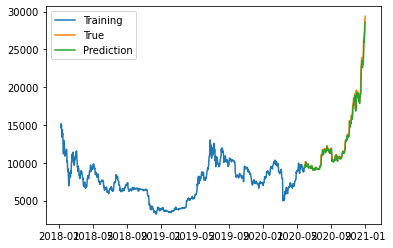

In [90]:
plt.plot(X_train.index, y_train, label="Training")
plt.plot(X_test.index, y_test, label="True")
plt.plot(X_test.index, preds, label="Prediction")
plt.legend()

Looks good right?

Any reason it might be suspiciously good? 🤔

In [94]:
list(zip(y_test[:10], preds[:10]))

[(9439.1240234375, 9453.054666376513),
 (9700.4140625, 9422.591496980647),
 (9461.05859375, 9627.828642324344),
 (10167.2685546875, 9441.415703828548),
 (9529.8037109375, 10093.536758149621),
 (9656.7177734375, 9519.623916209617),
 (9800.63671875, 9608.222660542207),
 (9665.533203125, 9708.2548513627),
 (9653.6796875, 9681.53257992136),
 (9758.8525390625, 9566.771988336546)]

Let's play around with:

- Predicting through using old predictions (a bit slow)
  - Also called a _Autoregressive model_
- Predicting further into the future
- ... & more

In [136]:
clf2 = SGDRegressor()
??clf2.partial_fit

Signature: clf2.partial_fit(X, y, sample_weight=None)
Source:   
    def partial_fit(self, X, y, sample_weight=None):
        """Perform one epoch of stochastic gradient descent on given samples.

        Internally, this method uses ``max_iter = 1``. Therefore, it is not
        guaranteed that a minimum of the cost function is reached after calling
        it once. Matters such as objective convergence and early stopping
        should be handled by the user.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            Subset of training data.

        y : numpy array of shape (n_samples,)
            Subset of target values.

        sample_weight : array-like, shape (n_samples,), default=None
            Weights applied to individual samples.
            If not provided, uniform weights are assumed.

        Returns
        -------
        self : object
            Returns an instance of self.
        """
        self._va

In [175]:
import torch

class TimeseriesDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, seq_len=1):
        self.X = torch.tensor(X)
        self.y = torch.tensor(y)
        self.seq_len = seq_len
    
    def __len__(self):
        return self.X.__len__() - (self.seq_len - 1)
    
    def __getitem__(self, index):
        return (self.X[index:index + self.seq_len], self.y[index + self.seq_len - 1])

In [176]:
train_dataset = TimeseriesDataset(y_train[:-1], y_train.shift(-1)[:-1], seq_len=7)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=False)
train_loader

In [192]:
for epoch in range(10):
    for batch in train_loader:
        clf2.partial_fit(batch[0], batch[1])

In [196]:
for batch in train_loader:
    print(f"X: {batch[0][:2]}")
    print(f"y: {batch[1][:2]}")
    break

X: tensor([[15170.0996, 14595.4004, 14973.2998, 13405.7998, 13980.5996, 14360.2002,
         13772.0000],
        [14595.4004, 14973.2998, 13405.7998, 13980.5996, 14360.2002, 13772.0000,
         13819.7998]], dtype=torch.float64)
y: tensor([13819.7998, 11490.5000], dtype=torch.float64)


**Excercise for the reader:**
- Create test dataset/loader
- Validate performance

#### Setting up a LSTM Forecaster
Including some `DropOut` and other things.

**Left as an excercise for the reader**

Read more [here](https://charlieoneill11.github.io/charlieoneill/lstm/pytorch/2022/01/12/lstm1.html).

<details>

```python
from torch import nn
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

model = LSTM()

loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)
```

</details>

#### Using a library, `darts`

There exist a multitude of libraries for this task, such as

- [darts](https://unit8co.github.io/darts/generated_api/darts.timeseries.html)
- [`tsai`](https://timeseriesai.github.io/tsai/)
- [sktime](https://www.sktime.org/en/stable/) by Alan Turing Institude
- [pytorch-forecasting](https://pytorch-forecasting.readthedocs.io/en/stable/)
- [tensorflow guide](https://www.tensorflow.org/tutorials/structured_data/time_series)

For this time I chose ...

In [ ]:
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import NBEATSModel, RNNModel, RandomForest, TCNModel, Prophet
from darts.utils.statistics import check_seasonality, plot_acf
from darts.metrics import mape

import pandas as pd

#### TSAI

In [192]:
from tsai.all import *
import datetime
import pandas_datareader as pdr

crypto_data = pdr.get_data_yahoo(['BTC-USD'], 
                          start=datetime.datetime(2019, 12, 31), 
                          end=datetime.datetime(2020, 12, 31))
crypto_data.head()

Attributes,Adj Close,Close,High,Low,Open,Volume
Symbols,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,,
2019-12-31,7193.599121,7193.599121,7335.290039,7169.777832,7294.438965,21167946112
2020-01-01,7200.174316,7200.174316,7254.330566,7174.944336,7194.892090,18565664997
2020-01-02,6985.470215,6985.470215,7212.155273,6935.270020,7202.551270,20802083465
2020-01-03,7344.884277,7344.884277,7413.715332,6914.996094,6984.428711,28111481032
2020-01-04,7410.656738,7410.656738,7427.385742,7309.514160,7345.375488,18444271275


In [193]:
btc = crypto_data[('Close', 'BTC-USD')]
btc.head()

Date
2019-12-31    7193.599121
2020-01-01    7200.174316
2020-01-02    6985.470215
2020-01-03    7344.884277
2020-01-04    7410.656738
Name: (Close, BTC-USD), dtype: float64

In [194]:
btc.to_csv('btc.csv')

In [195]:
X,y = SlidingWindow(window_len=7, horizon=1)(btc) # use stride to make samples not overlap if that makes sense. None has no overlaps.

In [196]:
X[:2]

array([[[7193.59912109, 7200.17431641, 6985.47021484, 7344.88427734,
         7410.65673828, 7411.31738281, 7769.21923828]],

       [[7200.17431641, 6985.47021484, 7344.88427734, 7410.65673828,
         7411.31738281, 7769.21923828, 8163.69238281]]])

In [78]:
btc[0],btc[7], X[0], y[0]

(1847.8399658203125,
 1883.1600341796875,
 array([[1847.83996582, 1898.01000977, 1874.9699707 , 1902.88000488,
         1906.85998535, 1891.9699707 , 1901.05004883, 1883.16003418,
         1891.30004883, 1869.43994141, 1862.02001953, 1877.93994141,
         1864.7199707 , 1892.        ]]),
 1887.4599609375)

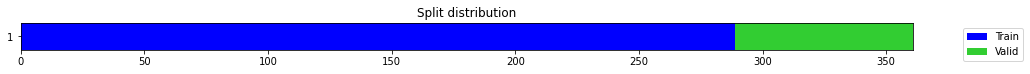

In [197]:
splits = TimeSplitter(0.2)(y) 
batch_tfms = [TSNormalize(use_single_batch=False)]

fcst = TSForecaster(X, y, splits=splits, batch_tfms=batch_tfms, arch=TST, metrics=mae, bs=512)

In [198]:
fcst.fit_one_cycle(50, 1e-2) # 1000 with 1e-1 is OK

epoch,train_loss,valid_loss,mae,time
0,90551048.000000,366132416.000000,18652.378906,00:00
1,90549224.000000,366117632.000000,18651.982422,00:00
2,90547528.000000,366087904.000000,18651.187500,00:00
3,90545088.000000,366025344.000000,18649.513672,00:00
4,90541824.000000,365893568.000000,18645.994141,00:00
5,90537376.000000,365616576.000000,18638.583984,00:00
6,90531592.000000,365072544.000000,18624.019531,00:00
7,90524160.000000,364310432.000000,18603.595703,00:00
8,90514392.000000,364224224.000000,18601.279297,00:00
9,90502016.000000,364367872.000000,18605.126953,00:00


In [200]:
_, y_true, preds = fcst.get_X_preds(X[:2], y[:2])

y_true, preds

(tensor([8163.6924, 8079.8628]), ([158.89918518066406], [171.23495483398438]))

#### FFT

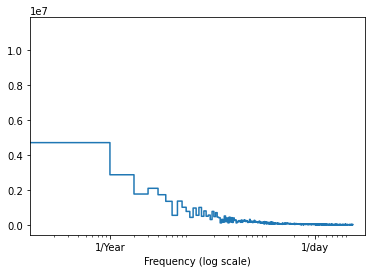

In [205]:
import numpy as np
df = pd.read_parquet("a.parquet")['Close']
fft = np.fft.rfft(df)

plt.step(range(len(fft)), abs(fft))

plt.xscale('log')
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### TODO

- Add `darts`
- Remove `tsai` ??
- Heidis data och predictions


- https://colab.research.google.com/drive/1WusArdwWA6iChrtf2ArZO6xHBM8kxRuS#scrollTo=3rkpOHkKyhtz
- https://unit8co.github.io/darts/quickstart/00-quickstart.html#Covariates:-using-external-data -- Covariates
- https://medium.com/financial-data-analysis/multiple-cryptocurrencies-pricing-prediction-using-lstm-python-a8e864176604
- https://medium.com/swlh/stock-price-prediction-with-pytorch-37f52ae84632

#### DARTS

In [ ]:
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import NBEATSModel, RNNModel, RandomForest, TCNModel, Prophet
from darts.utils.statistics import check_seasonality, plot_acf
from darts.metrics import mape

import pandas as pd

In [ ]:
# TimeSeries.from_dataframe(...)
# .split_after()

"""
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

model = NBEATSModel(input_chunk_length=24, output_chunk_length=1, random_state=42)
model.fit(train_transformed, epochs=50, verbose=True)

backtest_cov = model.historical_forecasts(
    series_transformed,
    start=0.9,
    forecast_horizon=1,
    retrain=False,
    verbose=True,
)
series_transformed.split_after(0.85)[1].plot(label="true")
backtest_cov.plot(label="pred")
plt.legend()

transformer.inverse_transform(series_transformed.split_after(0.7)[1]).plot(label="true")
transformer.inverse_transform(backtest_cov).plot(label="pred")
plt.legend()
"""

# Appendix

In [163]:
input_dim = 7
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 500

In [148]:
from torch import nn

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        out = self.fc(out[:, -1, :]) 
        return out

In [185]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, Normalizer

# a['Close'] /= a['Close'].max()

X, y = SlidingWindow(7)(a['Close'])
X = torch.tensor(X).float()
y = torch.tensor(y).float()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)

In [186]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [187]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(X_train)
    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time() - start_time
print("Training time: {}".format(training_time))


Epoch  0 MSE:  0.11753925681114197
Epoch  1 MSE:  0.09061731398105621
Epoch  2 MSE:  0.06548983603715897
Epoch  3 MSE:  0.042232632637023926
Epoch  4 MSE:  0.022303102537989616
Epoch  5 MSE:  0.008999793790280819
Epoch  6 MSE:  0.007621433585882187
Epoch  7 MSE:  0.018228771165013313
Epoch  8 MSE:  0.024359865114092827
Epoch  9 MSE:  0.021383972838521004
Epoch  10 MSE:  0.014771446585655212
Epoch  11 MSE:  0.009218874387443066
Epoch  12 MSE:  0.0065103028900921345
Epoch  13 MSE:  0.006348803173750639
Epoch  14 MSE:  0.00762241380289197
Epoch  15 MSE:  0.009224947541952133
Epoch  16 MSE:  0.010423221625387669
Epoch  17 MSE:  0.010911714285612106
Epoch  18 MSE:  0.010692129842936993
Epoch  19 MSE:  0.009936483576893806
Epoch  20 MSE:  0.00888850074261427
Epoch  21 MSE:  0.007799817714840174
Epoch  22 MSE:  0.006887165829539299
Epoch  23 MSE:  0.006300810258835554
Epoch  24 MSE:  0.006101526319980621
Epoch  25 MSE:  0.006250566802918911
Epoch  26 MSE:  0.006621480919420719
Epoch  27 MSE: 

In [188]:
preds = model(X_valid)

preds[:5], y_valid[:5]

(tensor([[0.2570],
         [0.2570],
         [0.2570],
         [0.2569],
         [0.2569]], grad_fn=<SliceBackward0>),
 tensor([0.3213, 0.3302, 0.3221, 0.3461, 0.3244]))

In [206]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [209]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(X_train)
    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.2312508374452591
Epoch  1 MSE:  0.15349167585372925
Epoch  2 MSE:  0.09167683124542236
Epoch  3 MSE:  0.0434187576174736
Epoch  4 MSE:  0.012879017740488052
Epoch  5 MSE:  0.00960458628833294
Epoch  6 MSE:  0.030343806371092796
Epoch  7 MSE:  0.03976194187998772
Epoch  8 MSE:  0.031092282384634018
Epoch  9 MSE:  0.01746959425508976
Epoch  10 MSE:  0.008485141210258007
Epoch  11 MSE:  0.006494820583611727
Epoch  12 MSE:  0.009332028217613697
Epoch  13 MSE:  0.01356985792517662
Epoch  14 MSE:  0.01661975122988224
Epoch  15 MSE:  0.017433052882552147
Epoch  16 MSE:  0.016137558966875076
Epoch  17 MSE:  0.01347370445728302
Epoch  18 MSE:  0.01039518229663372
Epoch  19 MSE:  0.007809631060808897
Epoch  20 MSE:  0.006377349141985178
Epoch  21 MSE:  0.006336060352623463
Epoch  22 MSE:  0.007393370848149061
Epoch  23 MSE:  0.008805749006569386
Epoch  24 MSE:  0.00974997878074646
Epoch  25 MSE:  0.00977612566202879
Epoch  26 MSE:  0.008978910744190216
Epoch  27 MSE:  0.00781885

In [210]:
preds = model(X_valid)

preds[:5], y_valid[:5]

(tensor([[0.2568],
         [0.2566],
         [0.2567],
         [0.2565],
         [0.2567]], grad_fn=<SliceBackward0>),
 tensor([0.3213, 0.3302, 0.3221, 0.3461, 0.3244]))